In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn

from scipy.sparse import coo_matrix
from scipy.stats import rankdata
from sklearn.preprocessing import StandardScaler

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
PAD_IDX = 0

In [3]:
# purpose: convert target with index of movie to series of all zeros and one in place of index
# We will use this to compute the expected output of the model to be compared with actual output
def idx_to_sparse(idx, sparse_dim):
    sparse = np.zeros(sparse_dim) # vector of 1683 zeroes
    sparse[int(idx)] = 1 # set a given index to 1
    return pd.Series(sparse, dtype=int) # make a pandas series of 0s and 1s


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# r,c = get_coo_indexes(dataset['prev movies'].tolist())
# print(len(r), len(c))
# 10150406 10150406
# print(r[:11], c[:11])
# [0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4] ['168', '168', '172', '168', '172', '165', '168', '172', '165', '156', '168']
# basically the information that row0 has 168, row1 has 168 and 172, row2 has 168, 172, 165 and so on..
# note that the length of first list represents number of "1s", while zip(first,second) gives row, col indices that should be one
def get_coo_indexes(lil):
    rows = []
    cols = []
    for i, el in enumerate(lil):
        if type(el)!=list:
            el = [el]
        for j in el:
            rows.append(i)
            cols.append(j)
    return rows, cols


# This function creates a sparse matrix given the "prev movies" column
def get_sparse_features(series, shape):
    # get row, column pairs such that column value represents the watched movie
    coo_indexes = get_coo_indexes(series.tolist())
    # Create a matrix of 0s and 1s of size orignal dataset rows and number of movies as columns; then convert it into coord based sparse matrix
    # sparse matrix would be of the size tuple (original rows count x number of movies); matrix starts with 1; we keep one extra column because movie id starts with 1 in the dataset
    # In the tuple, first argument specifies the number of 1s to be put in the sparse matrix, the second item (another tuple) specified row and column indexes for the positions where corresponding each value ie. 1 should be placed in the sparse matrix
    sparse_df = coo_matrix((np.ones(len(coo_indexes[0])), (coo_indexes[0], coo_indexes[1])), shape=shape)
    return sparse_df


# purpose: convert indexes of previous watched movies to series of films indexes
# given a sparse matrix input, this function returns a corresponding padded 2D matrix
# We use this to make binary features for the model training and testing
def sparse_to_idx(data, pad_idx=-1):
    # Returns a tuple of arrays (row,col) containing the indices of the non-zero elements of the matrix.
    indexes = data.nonzero()
    # for prev_movies_train, this dataset will be 7957390 rows × 2 columns because of repeating values of rows
    indexes_df = pd.DataFrame()
    indexes_df['rows'] = indexes[0]
    indexes_df['cols'] = indexes[1]
    
    # group by the rows, and make a list of all the corresponding columns
    # rows
    # 0                                [255, 286, 298, 185, 173]
    # 1                      [255, 286, 298, 185, 173, 772, 108]
    # 2                           [255, 286, 298, 185, 173, 772]
    # 3                 [255, 286, 298, 185, 173, 772, 108, 288]
    mdf = indexes_df.groupby('rows').apply(lambda x: x['cols'].tolist())
    max_len = mdf.apply(lambda x: len(x)).max() # longest list is 736 sized
    return mdf.apply(lambda x: pd.Series(x + [pad_idx] * (max_len - len(x)))).values # pad zeroes in the list upto 736 values; this result is (76228, 736) shaped

In [4]:
def load_and_process_data_deepfm():
    #Load the Ratings data
    data = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep="\t", header=None)
    data.columns = ['user id', 'movie id', 'rating', 'timestamp']
    #Load the User data
    users = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.user', sep="|", encoding='latin-1', header=None)
    users.columns = ['user id', 'age', 'gender', 'occupation', 'zip code']
    #Load movie data
    items = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', 
                    sep="|", encoding='latin-1', header=None)
    items.columns = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 
                     'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
                     'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                     'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    GENRES = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.genre', 
                     sep="|", header=None, usecols=[0])[0].tolist()
    
    # Sort the dataset by user-id and time
    dataset = data.sort_values(['user id', 'timestamp']).reset_index(drop=True)
    dataset['one'] = 1 # add a column containing all 1s
    dataset['sample_num'] = dataset.groupby('user id')['one'].cumsum() # use the 1s column to create a sample number for each user
    # Create a target column by shifting movie-id for each user-id one step back, effectively this means that we have a column that has id for the next movie the user is going to watch 
    # (it is NaN for the row representing the last movie the user watches). We will predict this column.
    dataset['target'] = dataset.groupby('user id')['movie id'].shift(-1)
    # create a column that represents average movie rating given by user till that time (represented by row)
    dataset['mean_rate'] = dataset.groupby('user id')['rating'].cumsum() / dataset['sample_num']
    
    # Create a column that has a list of movies that the user has watched so far. We will create sparse vector and embedding vectors from this later on.
    dataset['prev movies'] = dataset['movie id'].apply(lambda x: str(x))
    dataset['prev movies'] = dataset.groupby('user id')['prev movies'].apply(lambda x: (x + ' ').cumsum().str.strip())
    dataset['prev movies'] = dataset['prev movies'].apply(lambda x: x.split())
    
    # do a left join with movies dataframe and bring all the genre representations (0/1 binary values for each movie representing its category) here.
    dataset = dataset.merge(items[['movie id'] + GENRES], on='movie id', how='left')
    
    # For each genre column (19) creates another column (total 19 more). This column represents a given user's mean score (float value) for a given genre till that time (represented by row).
    # Note that we also update the genre columns such that each column now has cumulative sum, i.e. the corresponding number of movies that the user has watched in that genre so far.
    for genre in GENRES:
        dataset[f'{genre}_rate'] = dataset[genre]*dataset['rating']
        dataset[genre] = dataset.groupby('user id')[genre].cumsum()
        dataset[f'{genre}_rate'] = dataset.groupby('user id')[f'{genre}_rate'].cumsum() / dataset[genre]
    
    # Next we normalize the scores for movies in each genre such that we divide it by the number of movies that the user has watched so far.
    dataset[GENRES] = dataset[GENRES].apply(lambda x: x / dataset['sample_num'])
    # do a left-join on users data and get more information on users
    dataset = dataset.merge(users, on='user id', how='left')
    
    occupations_categoricals = dataset['occupation'].unique().tolist()

    dataset['gender'] = (dataset['gender'] == 'M').astype(int) # change gender to 0/1 integer
    dataset = pd.concat([dataset.drop(['occupation'], axis=1), pd.get_dummies(dataset[['occupation']], prefix="", prefix_sep="")], axis=1) # get occupation dummy variables and drop occupation column
    dataset.drop('zip code', axis=1, inplace=True)
    
    COLD_START_TRESH = 5 # take the rows AFTER each user has watched at least 4 movies
    # filter using threshold and remove null target rows
    filtred_data = dataset[(dataset['sample_num'] >= COLD_START_TRESH) &
                           ~(dataset['target'].isna())].sort_values('timestamp')
    
    continuous_cols = ['age', 'gender', 'mean_rate'] + GENRES + [gen+"_rate" for gen in GENRES] # 41
    categoricals = occupations_categoricals# already dummy encoded
    wide_data_column_names = continuous_cols + categoricals
    df_wide = filtred_data[wide_data_column_names]
    
    scaler = StandardScaler()
    pd.options.mode.chained_assignment = None
    
    TEST_SIZE = 0.2 # size of test set
    X_train_wide, X_test_wide = df_wide[:int(len(df_wide)*(1-TEST_SIZE))], df_wide[int(len(df_wide)*(1-TEST_SIZE)):]

    filtered_train_data, filtered_test_data = filtred_data[:int(len(filtred_data)*(1-TEST_SIZE))], filtred_data[int(len(filtred_data)*(1-TEST_SIZE)):]
    y_train, y_test = filtered_train_data['target'], filtered_test_data['target']
    
    # create sparse matrix out of prev_movies column for both train and test sets
    prev_movies_train = get_sparse_features(filtered_train_data['prev movies'], (len(filtered_train_data), filtred_data['movie id'].max()+1))
    prev_movies_test = get_sparse_features(filtered_test_data['prev movies'], (len(filtered_test_data), filtred_data['movie id'].max()+1))

    # tensor with sequence of indexes
    movies_train_tensor = torch.sparse_coo_tensor(
        indices=prev_movies_train.nonzero(), # The indices are the coordinates of the non-zero values in the matrix (7957390,7957390)
        values=[1]*len(prev_movies_train.nonzero()[0]), # Initial values for the tensor, 7957390 1s
        size=prev_movies_train.shape #  Size of the sparse tensor (76228, 1683)
    ).to_dense().to(device)
    
    movies_test_tensor = torch.sparse_coo_tensor(
        indices=prev_movies_test.nonzero(), 
        values=[1]*len(prev_movies_test.nonzero()[0]),
        size=prev_movies_test.shape
    ).to_dense().to(device)
    
    # Train part
    # tensor with binary features
    # to get embeddings for sequence of indexes
    movies_train_idx = torch.Tensor(
        sparse_to_idx(prev_movies_train, pad_idx=PAD_IDX),
    ).long().to(device)
    
    movies_test_idx = torch.Tensor(
        sparse_to_idx(prev_movies_test, pad_idx=PAD_IDX),
    ).long().to(device)
    
    # target
    target_train = torch.Tensor(y_train.values).long().to(device)
    target_test = torch.Tensor(y_test.values).long().to(device)
    target_test_sparse = y_test.apply(lambda x: idx_to_sparse(x, items['movie id'].nunique() + 1)) # to calculate mean rank over test set during training
    
    # tensor with continuous features
    X_train_wide_tensor = torch.Tensor(X_train_wide.fillna(0).values).to(device)
    X_test_wide_tensor = torch.Tensor(X_test_wide.fillna(0).values).to(device)
    
    return X_train_wide_tensor, X_test_wide_tensor, movies_train_tensor, movies_test_tensor, movies_train_idx, movies_test_idx, target_train, target_test, target_test_sparse, items['movie id'].nunique() + 1

class DeepFM(nn.Module):
    def __init__(self, embed_dim, embed_size, wide_dim, n_class, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(embed_dim, embed_size, padding_idx=pad_idx, device=device)
        self.linear_layer = nn.Linear(wide_dim, n_class, device=device)
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(embed_size, 1024, device=device),
            nn.ReLU(),
            nn.Linear(1024, 512, device=device),
            nn.ReLU(),
            nn.Linear(512, 256, device=device),
            nn.ReLU()
        )
        self.output = nn.Linear(256+1, n_class, device=device)

    def forward(self, X_w, X_sparse_idx):
        embed_x = self.embedding(X_sparse_idx) # movies_train_idx
        embed_x = torch.mean(embed_x, dim=1)
        
        # FM
        square_of_sum = torch.sum(embed_x, dim=1) ** 2
        sum_of_square = torch.sum(embed_x ** 2, dim=1)
        out_inter = 0.5 * (square_of_sum - sum_of_square)
        # Linear
        out_lin = self.linear_layer(X_w)
        # Deep
        out_deep = self.linear_relu_stack(embed_x)
        
        output = self.output(torch.cat((out_inter.unsqueeze(1), out_deep), dim=1)) + out_lin
        return output

def run_gradient_descent_deepfm(model,
    learning_rate=1e-3,
    weight_decay=0.01,
    num_epochs=10):
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX) # the model doesn't need to predict padding index
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    iters, train_losses, test_losses, mean_test_ranks = [], [], [], []
    
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        model.train()
        y_logits = model(torch.cat([X_train_wide_tensor, movies_train_tensor], dim=1), movies_train_idx)
        loss_train = loss_fn(y_logits, target_train)

        # Backpropagation
        optimizer.zero_grad() # a clean up step for PyTorch
        loss_train.backward() # compute updates for each parameter
        optimizer.step() # make the updates for each parameter

        # save the current training information
        if n%100 == 0:
            pred_train = torch.softmax(y_logits, dim=1).argmax(dim=1)
            acc = accuracy_fn(y_true=target_train, y_pred=pred_train)
            
            model.eval()
            with torch.inference_mode():
                test_logits = model(torch.cat([X_test_wide_tensor, movies_test_tensor], dim=1), movies_test_idx)
                test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
                loss_test = loss_fn(test_logits, target_test)
                test_acc = accuracy_fn(y_true=target_test,y_pred=test_pred)
            
            # calculate mean rank on test set
            softmax = nn.Softmax(dim=0)
            preds_wnd = softmax(test_logits.float()).cpu().detach().numpy()
            ranks_wnd = pd.DataFrame(preds_wnd).apply(lambda x: pd.Series(rankdata(-x)), axis=1)
            ranks_target_wnd = (ranks_wnd.values * target_test_sparse).sum(axis=1)
            mean_rank_wnd = ranks_target_wnd.mean()
            
            print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {test_acc:.2f}% Test mean rank: {mean_rank_wnd:.0f}")
            
            iters.append(n)
            train_losses.append(float(loss_train))
            test_losses.append(float(loss_test))
            mean_test_ranks.append(mean_rank_wnd)
            
            # increment the iteration number
        n += 1
    
    # plotting
    plt.figure(figsize=(12, 8), dpi=100)
    plt.title(f"Training Curve (lr={learning_rate})")
    plt.plot(iters, train_losses, label="Train Loss")
    plt.plot(iters, test_losses, label="Test Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 8), dpi=100)
    plt.plot(iters, mean_test_ranks, label="Test Rank")
    plt.xlabel("Iterations")
    plt.ylabel("Mean Rank on testset")
    plt.legend(loc='best')
    plt.show()
    
    return model, iters, train_losses, test_losses

In [5]:
X_train_wide_tensor, X_test_wide_tensor, movies_train_tensor, movies_test_tensor, movies_train_idx, movies_test_idx, target_train, target_test, target_test_sparse, n_classes = load_and_process_data_deepfm()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:207.)


In [6]:
deepfm_model = DeepFM(wide_dim=torch.cat([X_train_wide_tensor, movies_train_tensor], dim=1).shape[1],
        n_class=n_classes,
        embed_dim=n_classes,
        embed_size=16,) # randomly chosen

Epoch: 0 | Loss: 7.53568, Acc: 0.04% | Test Loss: 16.97324, Test Acc: 0.27% Test mean rank: 951
Epoch: 100 | Loss: 2.62395, Acc: 42.59% | Test Loss: 11.62288, Test Acc: 1.30% Test mean rank: 908
Epoch: 200 | Loss: 1.74222, Acc: 62.17% | Test Loss: 14.83390, Test Acc: 1.12% Test mean rank: 830
Epoch: 300 | Loss: 1.31452, Acc: 74.47% | Test Loss: 17.82988, Test Acc: 1.11% Test mean rank: 762
Epoch: 400 | Loss: 1.05564, Acc: 81.14% | Test Loss: 20.57037, Test Acc: 1.09% Test mean rank: 703
Epoch: 500 | Loss: 0.87396, Acc: 86.14% | Test Loss: 23.01068, Test Acc: 1.08% Test mean rank: 693
Epoch: 600 | Loss: 0.74620, Acc: 88.89% | Test Loss: 25.18114, Test Acc: 1.04% Test mean rank: 702
Epoch: 700 | Loss: 0.65234, Acc: 91.30% | Test Loss: 27.40661, Test Acc: 0.96% Test mean rank: 732
Epoch: 800 | Loss: 0.56963, Acc: 93.18% | Test Loss: 29.28725, Test Acc: 0.99% Test mean rank: 739
Epoch: 900 | Loss: 0.51674, Acc: 93.56% | Test Loss: 31.22412, Test Acc: 0.93% Test mean rank: 769
Epoch: 1000 |

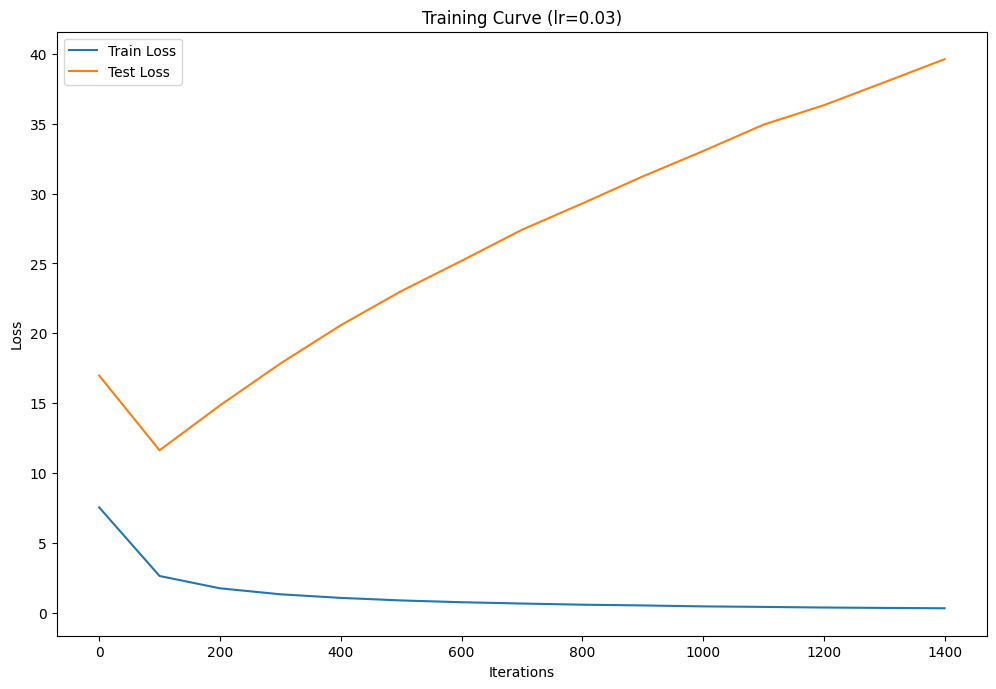

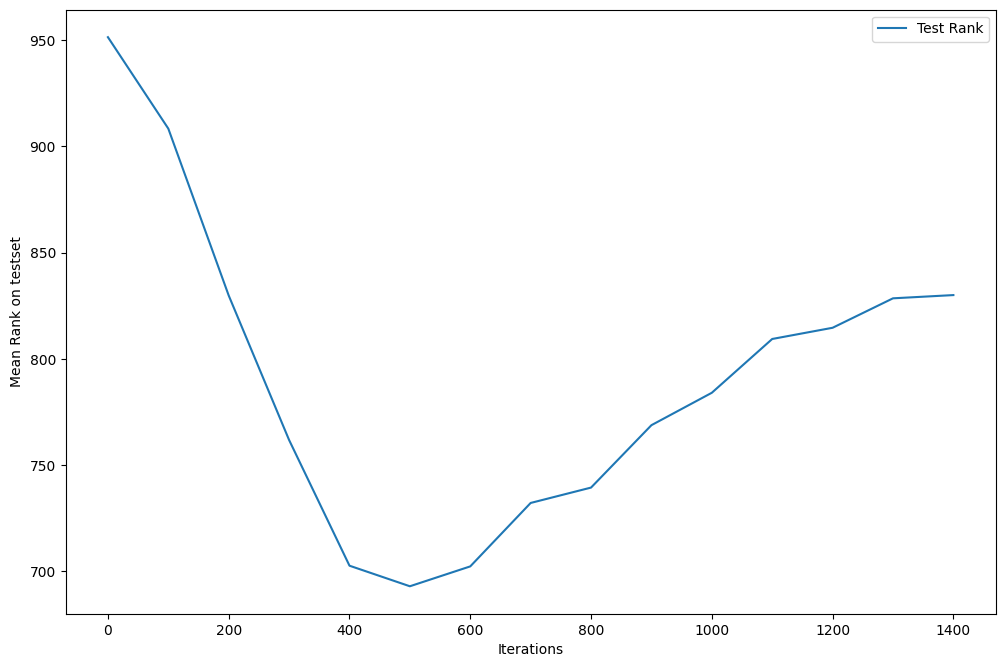

In [7]:
deepfm_model_trained, iters, train_losses, test_losses = run_gradient_descent_deepfm(deepfm_model, num_epochs=1500, weight_decay=0, learning_rate=0.03)